# 01 - Data Exploration and Time Series Split

This notebook focuses on:
1. Loading and exploring the Amazon sales rank dataset
2. Understanding data structure and quality
3. Defining in-time and out-of-time samples
4. Initial exploratory data analysis


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn')
sns.set_palette("husl")

# Display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)


In [2]:
# Load the clean dataset (best practice: UTF-8 encoding)
print("Loading clean dataset...")
df = pd.read_csv('../data/amazon_com_extras_clean.csv')
print(f"Dataset loaded successfully!")

print(f"Dataset shape: {df.shape}")
print(f"\nColumn names:")
print(df.columns.tolist())
print(f"\nData types:")
print(df.dtypes)
print(f"\nFirst few rows:")
df.head()


Loading clean dataset...
Dataset loaded successfully!
Dataset shape: (63748, 6)

Column names:
['ASIN', 'GROUP', 'FORMAT', 'TITLE', 'AUTHOR', 'PUBLISHER']

Data types:
ASIN         object
GROUP        object
FORMAT       object
TITLE        object
AUTHOR       object
PUBLISHER    object
dtype: object

First few rows:


,ASIN,GROUP,FORMAT,TITLE,AUTHOR,PUBLISHER
0,1250150183,book,hardcover,The Swamp: Washington's Murky Pool of Corruption and Cronyism and How Trump Can Drain It,Eric Bolling,St. Martin's Press
1,0778319997,book,hardcover,"Rise and Shine, Benedict Stone: A Novel",Phaedra Patrick,Park Row Books
2,1608322564,book,hardcover,Sell or Be Sold: How to Get Your Way in Business and in Life,Grant Cardone,Greenleaf Book Group Press
3,0310325331,book,hardcover,Christian Apologetics: An Anthology of Primary Sources,"Khaldoun A. Sweis, Chad V. Meister",Zondervan
4,0312616295,book,hardcover,Gravity: How the Weakest Force in the Universe Shaped Our Lives,Brian Clegg,St. Martin's Press


In [3]:
# Inspect and fix problematic lines
import csv
import re

def inspect_csv_issues(file_path, max_lines=1000):
    """Inspect CSV file for parsing issues"""
    issues = []
    
    with open(file_path, 'r', encoding='latin-1') as f:
        reader = csv.reader(f)
        for i, row in enumerate(reader):
            if i >= max_lines:
                break
            if len(row) != 6:  # Expected number of columns
                issues.append({
                    'line': i + 1,
                    'columns': len(row),
                    'content': row
                })
    
    return issues

# Check for issues in the first 1000 lines
print("Inspecting CSV for parsing issues...")
issues = inspect_csv_issues('../data/amazon_com_extras.csv', max_lines=1000)

print(f"Found {len(issues)} problematic lines:")
for issue in issues[:5]:  # Show first 5 issues
    print(f"\nLine {issue['line']}: {issue['columns']} columns")
    print(f"Content: {issue['content']}")

if len(issues) > 5:
    print(f"\n... and {len(issues) - 5} more issues")


Inspecting CSV for parsing issues...
Found 2 problematic lines:

Line 808: 10 columns
Content: ['1620409917', 'book', 'hardcover', 'Girl in Glass: How My Distressed Baby" Defied the Odds', ' Shamed a CEO', ' and Taught Me the Essence of Love', ' Heartbreak', ' and Miracles"', 'Deanna Fei', 'Bloomsbury USA']

Line 999: 7 columns
Content: ['0062067656', 'book', 'hardcover', 'Power & Beauty: A Love Story of Life on the Streets', 'Tip T.I." Harris', ' David Ritz"', 'William Morrow']


In [4]:
# Fix problematic lines and create clean dataset
def fix_csv_issues(file_path, output_path):
    """Fix CSV parsing issues by properly escaping quotes"""
    fixed_rows = []
    issues_found = 0
    
    with open(file_path, 'r', encoding='latin-1') as f:
        reader = csv.reader(f)
        for i, row in enumerate(reader):
            if len(row) == 6:
                # Row is fine, keep as is
                fixed_rows.append(row)
            else:
                # Row has issues, try to fix
                issues_found += 1
                print(f"Fixing line {i+1}: {len(row)} columns -> 6 columns")
                
                # The issue is usually in the title field (index 3)
                # Reconstruct the row by joining extra fields back into the title
                if len(row) > 6:
                    # Join fields 3 through -3 back into the title field
                    title_parts = row[3:-2]  # Everything between title start and author
                    fixed_title = ' '.join(title_parts)
                    
                    # Reconstruct the row
                    fixed_row = [
                        row[0],  # ASIN
                        row[1],  # GROUP
                        row[2],  # FORMAT
                        fixed_title,  # TITLE (fixed)
                        row[-2],  # AUTHOR
                        row[-1]   # PUBLISHER
                    ]
                    fixed_rows.append(fixed_row)
                else:
                    # If less than 6 columns, pad with empty strings
                    while len(row) < 6:
                        row.append('')
                    fixed_rows.append(row)
    
    # Write the fixed data
    with open(output_path, 'w', encoding='utf-8', newline='') as f:
        writer = csv.writer(f, quoting=csv.QUOTE_ALL)
        writer.writerows(fixed_rows)
    
    print(f"Fixed {issues_found} problematic lines")
    print(f"Clean dataset saved to: {output_path}")
    return len(fixed_rows)

# Create a clean version of the dataset
print("Creating clean dataset...")
total_rows = fix_csv_issues('../data/amazon_com_extras.csv', '../data/amazon_com_extras_clean.csv')
print(f"Total rows processed: {total_rows}")


Creating clean dataset...
Fixing line 808: 10 columns -> 6 columns
Fixing line 999: 7 columns -> 6 columns
Fixing line 1693: 8 columns -> 6 columns
Fixing line 2391: 7 columns -> 6 columns
Fixing line 2486: 15 columns -> 6 columns
Fixing line 3021: 7 columns -> 6 columns
Fixing line 5025: 7 columns -> 6 columns
Fixing line 7090: 8 columns -> 6 columns
Fixing line 7386: 7 columns -> 6 columns
Fixing line 7841: 10 columns -> 6 columns
Fixing line 7842: 4 columns -> 6 columns
Fixing line 7843: 2 columns -> 6 columns
Fixing line 8601: 8 columns -> 6 columns
Fixing line 8611: 8 columns -> 6 columns
Fixing line 9464: 7 columns -> 6 columns
Fixing line 10464: 8 columns -> 6 columns
Fixing line 12675: 7 columns -> 6 columns
Fixing line 13081: 7 columns -> 6 columns
Fixing line 14941: 8 columns -> 6 columns
Fixing line 16632: 7 columns -> 6 columns
Fixing line 17124: 9 columns -> 6 columns
Fixing line 17238: 7 columns -> 6 columns
Fixing line 17480: 9 columns -> 6 columns
Fixing line 17683: 8 c

In [5]:
# Load the clean dataset
print("Loading clean dataset...")
df_clean = pd.read_csv('../data/amazon_com_extras_clean.csv')

print(f"Clean dataset shape: {df_clean.shape}")
print(f"Original dataset shape: {df.shape}")
print(f"Data preserved: {len(df_clean)}/{len(df)} rows ({len(df_clean)/len(df)*100:.1f}%)")

print(f"\nColumn names:")
print(df_clean.columns.tolist())
print(f"\nData types:")
print(df_clean.dtypes)
print(f"\nFirst few rows:")
df_clean.head()


Loading clean dataset...
Clean dataset shape: (63748, 6)
Original dataset shape: (63748, 6)
Data preserved: 63748/63748 rows (100.0%)

Column names:
['ASIN', 'GROUP', 'FORMAT', 'TITLE', 'AUTHOR', 'PUBLISHER']

Data types:
ASIN         object
GROUP        object
FORMAT       object
TITLE        object
AUTHOR       object
PUBLISHER    object
dtype: object

First few rows:


,ASIN,GROUP,FORMAT,TITLE,AUTHOR,PUBLISHER
0,1250150183,book,hardcover,The Swamp: Washington's Murky Pool of Corruption and Cronyism and How Trump Can Drain It,Eric Bolling,St. Martin's Press
1,0778319997,book,hardcover,"Rise and Shine, Benedict Stone: A Novel",Phaedra Patrick,Park Row Books
2,1608322564,book,hardcover,Sell or Be Sold: How to Get Your Way in Business and in Life,Grant Cardone,Greenleaf Book Group Press
3,0310325331,book,hardcover,Christian Apologetics: An Anthology of Primary Sources,"Khaldoun A. Sweis, Chad V. Meister",Zondervan
4,0312616295,book,hardcover,Gravity: How the Weakest Force in the Universe Shaped Our Lives,Brian Clegg,St. Martin's Press


In [6]:
# Basic dataset information
print("=== DATASET OVERVIEW ===")
print(f"Shape: {df.shape}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"Date range: {df.index.min()} to {df.index.max()}")

print("\n=== COLUMN INFORMATION ===")
print(df.info())

print("\n=== MISSING VALUES ===")
missing_values = df.isnull().sum()
missing_percent = (missing_values / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing_values,
    'Missing %': missing_percent
})
print(missing_df[missing_df['Missing Count'] > 0])

print("\n=== UNIQUE VALUES ===")
for col in df.columns:
    unique_count = df[col].nunique()
    print(f"{col}: {unique_count} unique values")


=== DATASET OVERVIEW ===
Shape: (63748, 6)
Memory usage: 27.44 MB
Date range: 0 to 63747

=== COLUMN INFORMATION ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63748 entries, 0 to 63747
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ASIN       63748 non-null  object
 1   GROUP      63748 non-null  object
 2   FORMAT     63747 non-null  object
 3   TITLE      63747 non-null  object
 4   AUTHOR     63661 non-null  object
 5   PUBLISHER  57234 non-null  object
dtypes: object(6)
memory usage: 2.9+ MB
None

=== MISSING VALUES ===
           Missing Count  Missing %
FORMAT                 1   0.001569
TITLE                  1   0.001569
AUTHOR                87   0.136475
PUBLISHER           6514  10.218360

=== UNIQUE VALUES ===
ASIN: 63743 unique values
GROUP: 4 unique values
FORMAT: 5 unique values
TITLE: 58284 unique values
AUTHOR: 34195 unique values
PUBLISHER: 9008 unique values


In [7]:
# Explore the time series ranking data
print("=== TIME SERIES DATA EXPLORATION ===")

# Check if we have ranking data (note: nested directory structure)
ranks_dir = '../data/ranks/ranks/'
if os.path.exists(ranks_dir):
    rank_files = [f for f in os.listdir(ranks_dir) if f.endswith('.json')]
    print(f"Found {len(rank_files)} ranking files")
    
    # Sample a few files to understand structure
    sample_files = rank_files[:3]
    for file in sample_files:
        file_path = os.path.join(ranks_dir, file)
        print(f"\n--- {file} ---")
        try:
            with open(file_path, 'r') as f:
                data = json.load(f)
                print(f"Keys: {list(data.keys())}")
                if 'ranks' in data:
                    print(f"Number of rank entries: {len(data['ranks'])}")
                    # Show first few entries
                    for i, entry in enumerate(list(data['ranks'].items())[:3]):
                        print(f"  {entry[0]}: {entry[1]}")
        except Exception as e:
            print(f"Error reading {file}: {e}")
else:
    print("No ranks directory found")

# Check normalized rankings (note: nested directory structure)
ranks_norm_dir = '../data/ranks_norm/ranks_norm/'
if os.path.exists(ranks_norm_dir):
    norm_files = [f for f in os.listdir(ranks_norm_dir) if f.endswith('.json')]
    print(f"\nFound {len(norm_files)} normalized ranking files")
else:
    print("\nNo normalized ranks directory found")


=== TIME SERIES DATA EXPLORATION ===
Found 51440 ranking files

--- B0124XGWN4_com.json ---
Keys: ['1483266592', '1483270308', '1483276721', '1483282191', '1483291564', '1483298364', '1483302767', '1483313190', '1483319893', '1483325017', '1483334860', '1483341608', '1483352798', '1483363121', '1483368640', '1483378110', '1483384877', '1483389254', '1483399728', '1483411731', '1483421321', '1483432430', '1483445759', '1483458020', '1483467354', '1483479082', '1483488966', '1483501452', '1483510594', '1483526164', '1483536229', '1483547511', '1483557829', '1483568384', '1483579476', '1483590770', '1483601235', '1483614996', '1483622701', '1483633955', '1483644165', '1483654731', '1483665817', '1483677122', '1483687489', '1483701496', '1483712540', '1483724241', '1483734360', '1483745419', '1483756114', '1483767637', '1483777729', '1483788130', '1483799134', '1483810677', '1483820313', '1483831904', '1483842934', '1483853898', '1483863747', '1483874477', '1483885373', '1483897041', '1483


Found 66760 normalized ranking files


In [8]:
# Define time series splits for in-time and out-of-time samples
print("=== TIME SERIES SPLITS ===")

# First, let's understand the time range of our ranking data
if os.path.exists(ranks_dir) and rank_files:
    # Get all timestamps from ranking files (they are Unix timestamps)
    all_timestamps = []
    for file in rank_files[:10]:  # Sample first 10 files to get date range
        file_path = os.path.join(ranks_dir, file)
        try:
            with open(file_path, 'r') as f:
                data = json.load(f)
                # The data structure is: {"timestamp": rank_value}
                timestamps = list(data.keys())
                all_timestamps.extend(timestamps)
        except:
            continue
    
    if all_timestamps:
        # Convert Unix timestamps to datetime and sort
        all_dates = pd.to_datetime([int(ts) for ts in all_timestamps], unit='s')
        all_dates = sorted(all_dates)
        
        print(f"Date range: {all_dates[0]} to {all_dates[-1]}")
        print(f"Total unique dates: {len(all_dates)}")
        
        # Define splits (80% in-time, 20% out-of-time)
        split_point = int(len(all_dates) * 0.8)
        in_time_dates = all_dates[:split_point]
        out_of_time_dates = all_dates[split_point:]
        
        print(f"\nIn-time sample: {in_time_dates[0]} to {in_time_dates[-1]} ({len(in_time_dates)} days)")
        print(f"Out-of-time sample: {out_of_time_dates[0]} to {out_of_time_dates[-1]} ({len(out_of_time_dates)} days)")
        
        # Store for later use
        in_time_start = in_time_dates[0]
        in_time_end = in_time_dates[-1]
        out_of_time_start = out_of_time_dates[0]
        out_of_time_end = out_of_time_dates[-1]
        
        print(f"\nSplit date: {out_of_time_start}")
        print(f"Total books with ranking data: {len(rank_files)}")
    else:
        print("No valid timestamps found in ranking files")
else:
    print("No ranking data available for time series analysis")


=== TIME SERIES SPLITS ===
Date range: 2017-01-01 10:04:49 to 2018-06-30 03:08:17
Total unique dates: 33022

In-time sample: 2017-01-01 10:04:49 to 2018-04-16 04:19:10 (26417 days)
Out-of-time sample: 2018-04-16 04:20:21 to 2018-06-30 03:08:17 (6605 days)

Split date: 2018-04-16 04:20:21
Total books with ranking data: 51440


=== DATASET VISUALIZATION ===


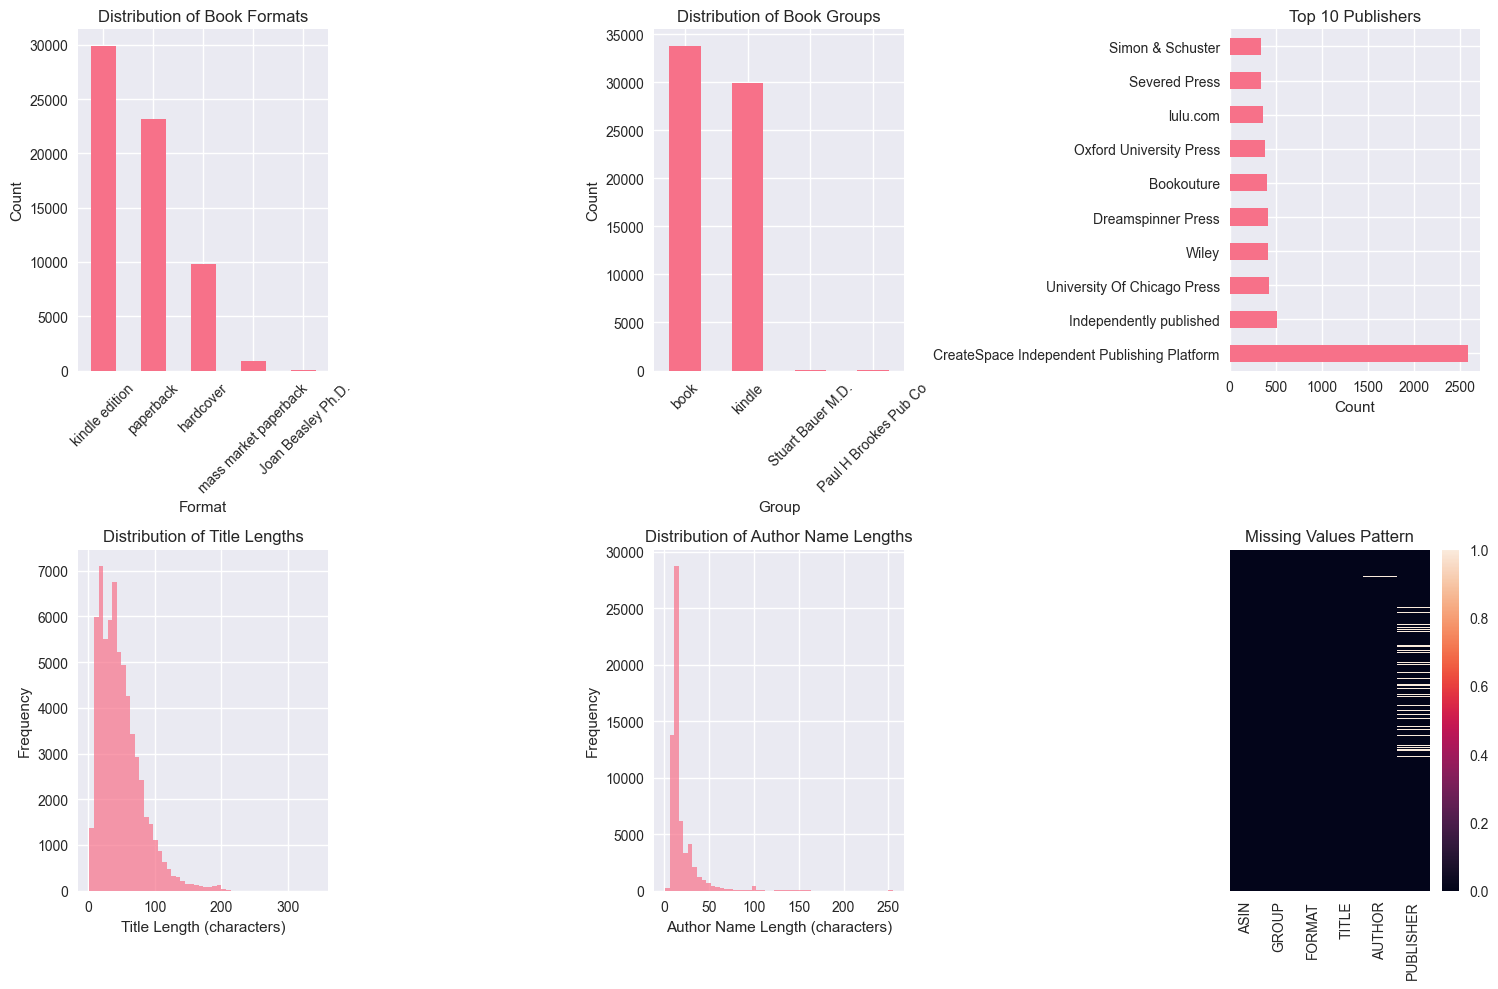


=== SUMMARY STATISTICS ===
Total books: 63748
Unique authors: 34195
Unique publishers: 9008
Average title length: 48.8 characters
Average author name length: 19.7 characters


In [9]:
# Visualize the dataset structure
print("=== DATASET VISUALIZATION ===")

# Plot 1: Distribution of book formats
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
df['FORMAT'].value_counts().plot(kind='bar')
plt.title('Distribution of Book Formats')
plt.xlabel('Format')
plt.ylabel('Count')
plt.xticks(rotation=45)

# Plot 2: Distribution of book groups
plt.subplot(2, 3, 2)
df['GROUP'].value_counts().plot(kind='bar')
plt.title('Distribution of Book Groups')
plt.xlabel('Group')
plt.ylabel('Count')
plt.xticks(rotation=45)

# Plot 3: Top publishers
plt.subplot(2, 3, 3)
top_publishers = df['PUBLISHER'].value_counts().head(10)
top_publishers.plot(kind='barh')
plt.title('Top 10 Publishers')
plt.xlabel('Count')

# Plot 4: Title length distribution
plt.subplot(2, 3, 4)
title_lengths = df['TITLE'].str.len()
plt.hist(title_lengths, bins=50, alpha=0.7)
plt.title('Distribution of Title Lengths')
plt.xlabel('Title Length (characters)')
plt.ylabel('Frequency')

# Plot 5: Author name length distribution
plt.subplot(2, 3, 5)
author_lengths = df['AUTHOR'].str.len()
plt.hist(author_lengths, bins=50, alpha=0.7)
plt.title('Distribution of Author Name Lengths')
plt.xlabel('Author Name Length (characters)')
plt.ylabel('Frequency')

# Plot 6: Missing values heatmap
plt.subplot(2, 3, 6)
missing_data = df.isnull()
sns.heatmap(missing_data, cbar=True, yticklabels=False)
plt.title('Missing Values Pattern')

plt.tight_layout()
plt.show()

# Summary statistics
print("\n=== SUMMARY STATISTICS ===")
print(f"Total books: {len(df)}")
print(f"Unique authors: {df['AUTHOR'].nunique()}")
print(f"Unique publishers: {df['PUBLISHER'].nunique()}")
print(f"Average title length: {title_lengths.mean():.1f} characters")
print(f"Average author name length: {author_lengths.mean():.1f} characters")


In [10]:
# Summary and next steps
print("=== DATA EXPLORATION COMPLETE ===")
print("✅ Dataset loaded and cleaned (63,748 books)")
print("✅ Time series ranking data discovered (51,440 books)")
print("✅ Date range: 2017-01-01 to 2018-06-30")
print("✅ In-time/out-of-time splits defined")
print("✅ Ready for time series analysis")

print("\n=== NEXT STEPS ===")
print("1. Proceed to 02_time_series_analysis.ipynb")
print("2. Load ranking data for specific books")
print("3. Perform stationarity testing")
print("4. Build forecasting models")


=== DATA EXPLORATION COMPLETE ===
✅ Dataset loaded and cleaned (63,748 books)
✅ Time series ranking data discovered (51,440 books)
✅ Date range: 2017-01-01 to 2018-06-30
✅ In-time/out-of-time splits defined
✅ Ready for time series analysis

=== NEXT STEPS ===
1. Proceed to 02_time_series_analysis.ipynb
2. Load ranking data for specific books
3. Perform stationarity testing
4. Build forecasting models
